In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import pickle

In [3]:
import numpy as np
import pandas as pd

In [4]:
from decode_tueg import (
    deconfound, load_exp, _create_final_scores, plot_age_gap_hist, plot_heatmaps,
    save_csv, plot_age_gap_hist_and_permutation_test, DataScaler, TargetScaler,
    Augmenter, iter_exp_dir,
)

Mon Apr 24 14:43:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:B2:00.0 Off |                  N/A |
| 27%   25C    P8    22W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
exp_dir = '/home/jovyan/experiments/'
exp_date = '2023-02-15T18:43:26.819382'
checkpoint = 'train_end'

In [6]:
save = False
recording_ids = list(range(20, 30))

In [7]:
def get_final_eval_predictions(recording_ids):
    datasets = {'eval': None, 'eval_not_normal': None}
    for ds_name in datasets.keys():
        with open(f'/home/jovyan/{ds_name}_pre_win.pkl', 'rb') as f:
            ds = pickle.load(f)
        if recording_ids is not None:
            ds = ds.split(recording_ids)['0']
        datasets[ds_name] = ds
    datasets['eval_not_normal'].transform = datasets['eval'].transform[0]
    datasets['eval_not_normal'].target_transform = datasets['eval'].target_transform
    
    predictions = {k: {} for k in datasets.keys()}
    for ds_name, ds in datasets.items():
        y_pred, y_true = estimator.predict_trials(ds)
        predictions[f'{ds_name}']['y_true'] = ds.target_transform.invert(y_true)
        predictions[f'{ds_name}']['y_pred'] = [ds.target_transform.invert(y) for y in y_pred]
        predictions[ds_name]['description'] = ds.description
    return predictions

In [8]:
# only loading one of five runs

In [9]:
for exp_path in iter_exp_dir(exp_dir, exp_date):
    print(f'loading exp {exp_path}')
    estimator, data_scaler, target_scaler, config = load_exp(
        exp_dir, exp_path, checkpoint)
    predictions = get_final_eval_predictions(recording_ids)
    break


loading exp 2023-02-15T18:43:26.819382/20230214/0


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

/tmp/ipykernel_788/1789750928.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [11]:
import torch

In [12]:
n_preds_per_input = estimator.module(torch.ones(1, 21, 6000, 1).cuda()).shape[-1]

In [13]:
i = None
j = None
#n = None

In [14]:
colors = plt.get_cmap('tab10').colors

In [15]:
# plot predictions over time

Text(0, 0.5, 'Age [years]')

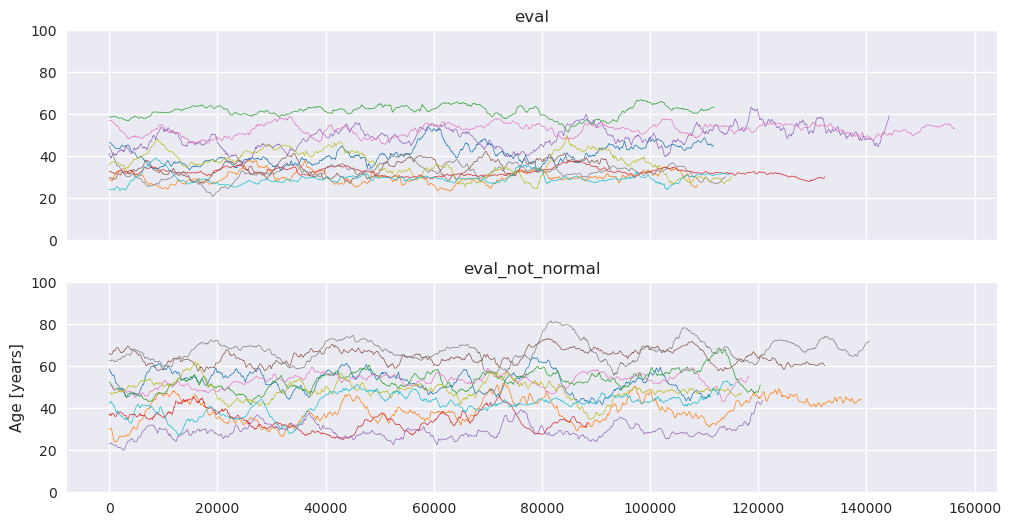

In [16]:
fig, ax_arr = plt.subplots(len(predictions), 1, figsize=(12, 3*len(predictions)), sharex=True, sharey=True)
for ds_i, (ds_name, ds_preds) in enumerate(predictions.items()):
    ax = ax_arr[ds_i]
    for rec_i, (rec_preds, rec_label) in enumerate(zip(ds_preds['y_pred'], ds_preds['y_true'])):
        # compute sliding window mean of size n_preds_per_input
        preds = np.correlate(rec_preds.squeeze(), np.ones(n_preds_per_input) / n_preds_per_input)[i:j]
        ax = sns.lineplot(preds, ax=ax, c=colors[rec_i], linewidth=.5)
        #ax.plot([0, len(preds)], [preds.mean(), preds.mean()], c=colors[rec_i], linewidth=1)
        #ax.axhline(preds.mean(), linestyle='--', label='mean')#, c='cyan')
        #ax.axhline(np.median(preds), linestyle=':', label='median')#, c='cyan')
        #ax.axhline(rec_label, label='true')#, c='cyan')
        ax.set_title(ds_name)
        #ax.set_xlabel([l/ax.get_xlabel())
ax.legend()
ax.set_ylim(0, 100)
ax.set_ylabel('Age [years]')

In [17]:
# show distribution of precictions per class and rec

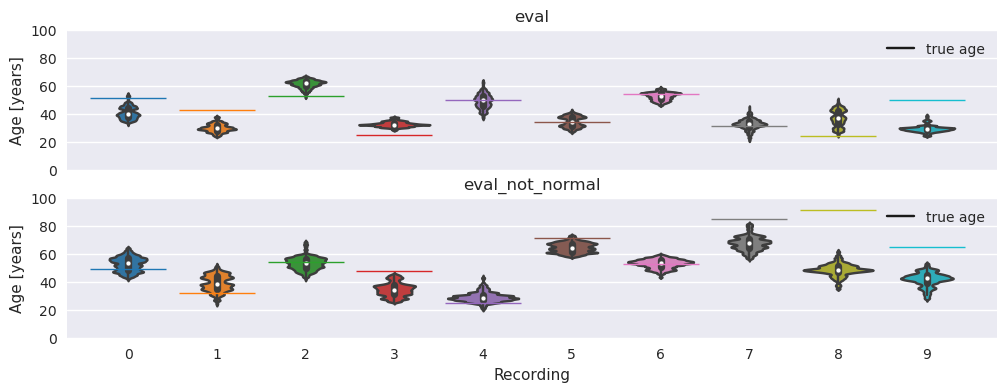

In [18]:
fig, ax_arr = plt.subplots(len(predictions), 1, figsize=(12, 2*len(predictions)), sharex=True, sharey=True)
for ds_i, (ds_name, ds_preds) in enumerate(predictions.items()):
    ax = ax_arr[ds_i]
    dfs = []
    for rec_i, (rec_preds, rec_label) in enumerate(zip(ds_preds['y_pred'], ds_preds['y_true'])):
        # compute sliding window mean of size n_preds_per_input
        preds = np.correlate(rec_preds.squeeze(), np.ones(n_preds_per_input) / n_preds_per_input)[i:j]
        ax = sns.scatterplot(
            x=[rec_i], y=[rec_label], 
            c=colors[rec_i], ax=ax, zorder=101, 
            marker='_', s=3000, linewidth=1,
        )
        df = pd.DataFrame({'x': np.ones(len(preds), dtype=int)*rec_i, 'y_pred': preds})
        dfs.append(df)
    dfs = pd.concat(dfs)
    sns.violinplot(dfs, x='x', y='y_pred', palette=colors, ax=ax)
    ax.set_ylabel('Age [years]')
    ax.set_xlabel('Recording')
    ax.set_title(ds_name)
    ax.set_ylim(0, 100)
    ax.plot([0,0], [110, 110], label='true age', c='k')
    ax.legend()

In [19]:
# -> bigger difference to label for not normal class

In [20]:
# show distribution of predictions of all recs per class de-meaned or de-labeled

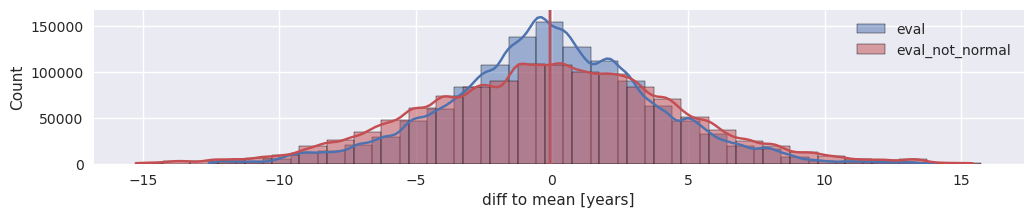

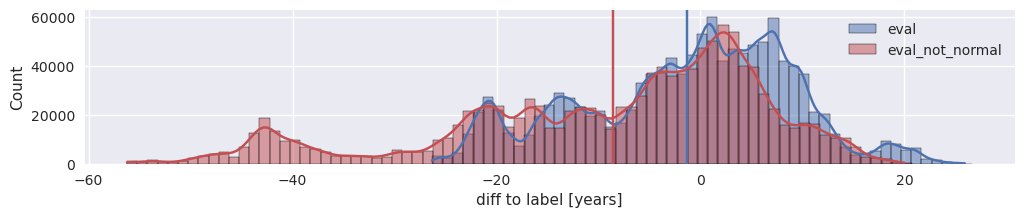

In [21]:
for diff_to in ['mean', 'label']:
    all_preds = {}
    for ds_i, (ds_name, ds_preds) in enumerate(predictions.items()):
        all_preds[ds_name] = []
        for rec_i, (rec_preds, rec_label) in enumerate(zip(ds_preds['y_pred'], ds_preds['y_true'])):
            if diff_to == 'label':
                rec_preds = rec_preds - rec_label
            else:
                assert diff_to == 'mean'
                rec_preds = rec_preds - rec_preds.mean()
            preds = np.correlate(rec_preds.squeeze(), np.ones(n_preds_per_input) / n_preds_per_input)[i:j]
            all_preds[ds_name].extend(list(preds))

    colors = ['b', 'r']
    fig, ax = plt.subplots(1, 1, figsize=(12,2))
    for ds_i, (ds_name, preds) in enumerate(all_preds.items()):
        ax = sns.histplot(preds, kde=True, binwidth=1, ax=ax, color=colors[ds_i], label=ds_name)
        ax.axvline(np.mean(preds), c=colors[ds_i])
    ax.legend()
    ax.set_xlabel(f'diff to {diff_to} [years]')

In [22]:
# -> dist of diff to label = brain age gap
# -> dist of diff to mean 

In [23]:
# compute mae on median predictions instead of on mean

In [24]:
from sklearn.metrics import mean_absolute_error

In [25]:
for agg in ['mean', 'median']:
    print(agg)
    for ds_i, (ds_name, ds_preds) in enumerate(predictions.items()):
        all_rec_preds, all_rec_labels = [], []
        for rec_i, (rec_preds, rec_label) in enumerate(zip(ds_preds['y_pred'], ds_preds['y_true'])):
            if agg == 'median':
                all_rec_preds.append(np.median(rec_preds))
            else:
                assert agg == 'mean'
                all_rec_preds.append(np.mean(rec_preds))
            all_rec_labels.append(rec_label)
        print(ds_name)
        print(mean_absolute_error(all_rec_preds, all_rec_labels))
    print()

mean
eval
7.6796923
eval_not_normal
11.874052

median
eval
8.502535
eval_not_normal
11.687372



In [26]:
# -> median eval lower, eval_not_normal higher

In [27]:
# look on time-series predictions and input signals simultaneously

In [28]:
for ds_i, (ds_name, ds_preds) in enumerate(predictions.items()):
    all_rec_preds, all_rec_labels = [], []
    for rec_i, (rec_preds, rec_label, rec_desc) in enumerate(zip(
        ds_preds['y_pred'], ds_preds['y_true'], ds_preds['description'].iterrows())):
        _
    _

In [29]:
import mne

In [30]:
raw = mne.io.read_raw_edf(rec_desc[1].path, verbose='error', infer_types=True)

In [31]:
i, j = -3000, -2000

In [32]:
# TODO: correctly match raw data and predictions!

In [33]:
n_preds_per_input = estimator.module(torch.ones(1, 21, 6000, 1).cuda()).shape[-1]
n_preds_per_input = 1

Text(0, 0.5, 'Prediction [years]')

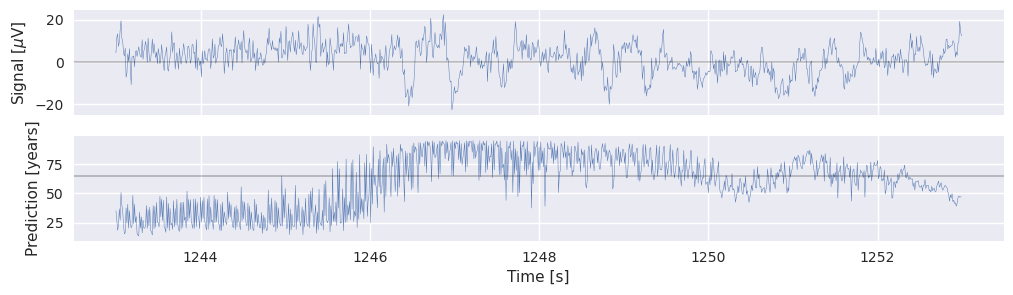

In [34]:
data, times = raw.get_data(picks='O1', return_times=True, units='uV')
data = data[:, i:j]
times = times[i:j]

fig, ax_arr = plt.subplots(2, 1, figsize=(12, 3), sharex=True)
ax = ax_arr[0]
ax.plot(times, data.T, linewidth=.33)
ax.axhline(0, c='k', linewidth=.33)
ax.set_ylabel('Signal [$\mu$V]')

ax = ax_arr[1]
preds = np.correlate(rec_preds.squeeze(), np.ones(n_preds_per_input) / n_preds_per_input)[i:j]
ax.plot(times, preds, linewidth=.33)
ax.axhline(rec_label, c='k', linewidth=.33)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Prediction [years]')

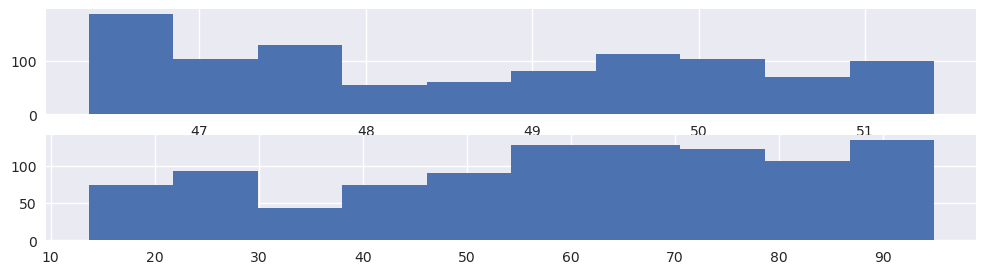

In [35]:
fig, ax_arr = plt.subplots(2, 1, figsize=(12, 3))#, sharex=True)
ax = ax_arr[0]
n_preds_per_input = estimator.module(torch.ones(1, 21, 6000, 1).cuda()).shape[-1]
preds = np.correlate(rec_preds.squeeze(), np.ones(n_preds_per_input) / n_preds_per_input)[i:j]
ax.hist(preds);

ax = ax_arr[1]
n_preds_per_input = 1
preds = np.correlate(rec_preds.squeeze(), np.ones(n_preds_per_input) / n_preds_per_input)[i:j]
ax.hist(preds);